## Make LFP

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#dj.conn() 
#dj.config

In [3]:
import os
import numpy as np
import pandas as pd

import spyglass as nd
import datajoint as dj
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
warnings.simplefilter('ignore', category=UserWarning)

import matplotlib.pyplot as plt

In [6]:
# We also import a bunch of tables so that we can call them easily
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode)
from spyglass.common import (RawPosition, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  PositionSource,
                                  IntervalList, 
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, AnalysisNwbfileKachery) #SortGroup, SpikeSorting, SpikeSorter, SpikeSorterParameters, 
                                  #SpikeSortingWaveformParameters, SpikeSortingParameters, SpikeSortingMetrics, CuratedSpikeSorting, AutomaticCurationSpikeSortingParameters,SortInterval,
    
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)
from spyglass.common import FirFilterParameters

from spyglass.shijiegu.load import load_session_name
from spyglass.shijiegu.ripple_detection import loadRippleLFP_OneChannelPerElectrode

In [7]:
FirFilterParameters()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Delta 0.5-4 Hz,1000,lowpass,0.25,0.5,4.0,5.0,delta filter for 1 KHz data,=BLOB=,=BLOB=
"Delta 0.5-4 Hz pass, 0.25-4.5 Hz stop",1000,lowpass,0.25,0.5,4.0,4.5,revised delta filter for 1 KHz data,=BLOB=,=BLOB=
Epilepsy project 0.2-40 Hz,2000,bandpass,0.1,0.2,40.0,41.0,Sharp wave filter,=BLOB=,=BLOB=
Epilepsy project 140-800 Hz,2000,bandpass,135.0,140.0,800.0,825.0,Extended ripple filter,=BLOB=,=BLOB=
Epilepsy project 140-800 Hz ripple,2000,bandpass,135.0,140.0,800.0,825.0,Extended ripple filter,=BLOB=,=BLOB=
Epilepsy project 40-600 Hz,2000,bandpass,39.0,40.0,600.0,625.0,HFE filter,=BLOB=,=BLOB=
Fast Gamma 65-100 Hz,1000,bandpass,55.0,65.0,100.0,110.0,slow gamma filter for 1 Khz data,=BLOB=,=BLOB=
LFP 0-100 Hz,30000,lowpass,0.0,0.0,100.0,125.0,LFP filter 0-100 Hz,=BLOB=,=BLOB=
LFP 0-400 Hz,1000,lowpass,0.0,0.0,400.0,425.0,LFP filter for referencing,=BLOB=,=BLOB=
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=


## investigate why some timestamps are nan

In [118]:
from spyglass.common.common_interval import (
    IntervalList,
    interval_list_contains_ind,
    interval_list_intersect,
)

In [146]:
from spyglass.utils.nwb_helper_fn import (
    estimate_sampling_rate,
    get_config,
    get_data_interface,
    get_electrode_indices,
    get_nwb_file,
    get_valid_intervals,
)

In [ ]:
['eliot20221017.nwb','eliot20221020.nwb','eliot20221024.nwb']

In [178]:
nwb_file_name = 'eliot20221024.nwb'
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
key = {'nwb_file_name' : nwb_copy_file_name}
key["interval_list_name"] = "01_Seq2Sleep1"

In [199]:
lfp_object = (
            LFP() & {"nwb_file_name": key["nwb_file_name"]}
        ).fetch_nwb()[0]["lfp"]

[2024-09-05 11:19:33,655][WARNING]: Skipped checksum for file with hash: 6729d422-9395-6c8a-f516-e9875317e58a, and path: /stelmo/nwb/analysis/eliot20221024/eliot20221024_DF6H6Z3GJ1.nwb


In [198]:
key

{'nwb_file_name': 'eliot20221024_.nwb',
 'interval_list_name': '01_Seq2Sleep1',
 'target_interval_list_name': '11_Seq2Sleep6',
 'filter_name': 'Ripple 150-250 Hz'}

In [186]:
rawdata = Raw().nwb_object(key)

In [222]:
timestamps_raw = np.array(rawdata.timestamps,dtype=type(rawdata.timestamps[0]))

In [241]:
ind = np.argwhere(np.isnan(timestamps_raw)).ravel()[0]
print(ind)

173368026


In [234]:
(timestamps_raw[ind-2] - timestamps_raw[ind-3])

3.337860107421875e-05

In [235]:
(timestamps_raw[ind+1] - timestamps_raw[ind-1])

6.651878356933594e-05

In [231]:
for t in [ind - 3, ind - 2, ind - 1, ind, ind + 1, ind + 2]:
    print(timestamps_raw[t] - timestamps_raw[t-1])
    #print(timestamps_raw[t])

3.314018249511719e-05
3.337860107421875e-05
0.00013327598571777344
nan
nan
3.361701965332031e-05


In [223]:
np.sum(np.isnan(timestamps_raw))

1

In [236]:
nwb_file_name = key["nwb_file_name"]
nwb_file_abspath = Nwbfile.get_abs_path(nwb_file_name)
nwbf = get_nwb_file(nwb_file_abspath)

In [237]:
rawdata = nwbf.get_acquisition()

In [238]:
timestamps_raw = np.array(rawdata.timestamps,dtype=type(rawdata.timestamps[0]))

In [239]:
np.sum(np.isnan(timestamps_raw))

1

In [240]:
np.argwhere(np.isnan(timestamps_raw))

array([[173368026]])

In [180]:
# get the electrodes to be filtered and their references
lfp_band_elect_id, lfp_band_ref_id = (
    LFPBandSelection().LFPBandElectrode() & key
).fetch("electrode_id", "reference_elect_id")

# sort the electrodes to make sure they are in ascending order
lfp_band_elect_id = np.asarray(lfp_band_elect_id)
lfp_band_ref_id = np.asarray(lfp_band_ref_id)
lfp_sort_order = np.argsort(lfp_band_elect_id)
lfp_band_elect_id = lfp_band_elect_id[lfp_sort_order]
lfp_band_ref_id = lfp_band_ref_id[lfp_sort_order]

In [196]:
lfp_object.timestamps[0]

1666632719.8950195

In [212]:
timestamps = np.asarray(lfp_object.timestamps,dtype=type(lfp_object.data[0][0]))
np.sum(np.isnan(timestamps))

0

In [213]:
for t in [5778914, 5778915, 5778916, 5778917, 5778918]:
    print(timestamps[t])

32767
32767
0
32767
32767


In [205]:
timestamps = np.asarray(lfp_object.timestamps)
np.sum(np.isnan(timestamps))

1

In [206]:
np.argwhere(np.isnan(timestamps))

array([[5778916]])

In [211]:
for t in [5778914, 5778915, 5778916, 5778917, 5778918]:
    print(timestamps[t])

1666638833.3670866
1666638833.3680866
nan
1666638833.3748534
1666638833.3758533


In [183]:
timestamps = np.asarray(lfp_object.timestamps)
lfp_data = lfp_object.data

In [184]:
intervals = ((TaskEpoch & {'nwb_file_name': nwb_copy_file_name})).fetch("interval_list_name")

In [185]:
lfp_sampling_rate = (
            LFP() & {"nwb_file_name": key["nwb_file_name"]}
        ).fetch1("lfp_sampling_rate")


for interval in intervals:
    timestamps = np.asarray(lfp_object.timestamps)
    
    key["target_interval_list_name"] = interval
    
    key["filter_name"] = "Ripple 150-250 Hz"
    interval_list_name, lfp_band_sampling_rate = (
        LFPBandSelection() & key).fetch1("target_interval_list_name", "lfp_band_sampling_rate")
    valid_times = (
        IntervalList()
        & {
            "nwb_file_name": key["nwb_file_name"],
            "interval_list_name": interval,
        }).fetch1("valid_times")
    # the valid_times for this interval may be slightly beyond the valid times for the lfp itself,
    # so we have to intersect the two
    lfp_interval_list = (
                LFP() & {"nwb_file_name": key["nwb_file_name"]}
            ).fetch1("interval_list_name")
    lfp_valid_times = (
                IntervalList()
                & {
                    "nwb_file_name": key["nwb_file_name"],
                    "interval_list_name": lfp_interval_list,
                }
            ).fetch1("valid_times")
    min_length = (LFPBandSelection & key).fetch1("min_interval_len")
    lfp_band_valid_times = interval_list_intersect(
                valid_times, lfp_valid_times, min_length=min_length
            )

    decimation = int(lfp_sampling_rate) // lfp_band_sampling_rate

    included_indices = interval_list_contains_ind(
                lfp_band_valid_times, timestamps
            )
    print(included_indices)
    if len(included_indices) == 0:
        continue

    # pad the indices by 1 on each side to avoid message in filter_data
    if included_indices[0] > 0:
        included_indices[0] -= 1
    if included_indices[-1] != len(timestamps) - 1:
        included_indices[-1] += 1

    timestamps = timestamps[included_indices[0] : included_indices[-1]]

    # load all the data to speed filtering
    lfp_data = np.asarray(
        lfp_object.data[included_indices[0] : included_indices[-1], :],
        dtype=type(lfp_object.data[0][0]),
    )

    # get the indices of the electrodes to be filtered and the references
    lfp_band_elect_index = get_electrode_indices(
        lfp_object, lfp_band_elect_id
    )
    lfp_band_ref_index = get_electrode_indices(lfp_object, lfp_band_ref_id)

    # subtract off the references for the selected channels
    for index, elect_index in enumerate(lfp_band_elect_index):
        if lfp_band_ref_id[index] != -1:
            lfp_data[:, elect_index] = (
                lfp_data[:, elect_index]
                - lfp_data[:, lfp_band_ref_index[index]]
            )

     # get the LFP filter that matches the raw data
    filter = (
            FirFilterParameters()
            & {"filter_name": key["filter_name"]}
    ).fetch(as_dict=True)

    filter_coeff = filter[0]["filter_coeff"]

    filtered_data, new_timestamps = FirFilterParameters().filter_data(
            timestamps,
            lfp_data,
            filter_coeff,
            lfp_band_valid_times,
            lfp_band_elect_index,
            decimation,
        )

[      1       2       3 ... 1911548 1911549 1911550]


[22:10:31][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666634631.4471567 < 1666634631.4468422


[1911552 1911553 1911554 ... 3638883 3638884 3638885]


[22:12:39][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666636531.1469316 < 1666636531.1467433


[3638887 3638888 3638889 ... 5698268 5698269 5698270]


[22:14:56][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666638701.4477081 < 1666638701.4469771


[5698272 5698273 5698274 ... 7664386 7664387 7664388]


[22:17:17][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666640718.8475463 < 1666640718.8473918


[7664390 7664391 7664392 ... 9134647 9134648 9134649]


[22:19:35][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666643960.1470754 < 1666643960.1469188


[ 9134650  9134651  9134652 ... 10922048 10922049 10922050]


[22:21:22][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666645802.2475495 < 1666645802.2472


[10922052 10922053 10922054 ... 12788071 12788072 12788073]


[22:23:34][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666647933.5473642 < 1666647933.546479


[12788075 12788076 12788077 ... 14484219 14484220 14484221]


[22:25:40][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666649686.0470815 < 1666649686.0467618


[14484223 14484224 14484225 ... 16214719 16214720 16214721]


[22:27:42][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666651510.747705 < 1666651510.7468932


[16214723 16214724 16214725 ... 18109675 18109676 18109677]
[18109679 18109680 18109681 ... 19639007 19639008 19639009]


[22:31:59][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666655063.2460878 < 1666655063.2450879


In [172]:
interval

'02_Seq2Session2'

In [156]:
lfp_band_valid_times

array([[1.66663480e+09, 1.66663491e+09],
       [1.66663491e+09, 1.66663503e+09],
       [1.66663503e+09, 1.66663640e+09],
       [1.66663640e+09, 1.66663653e+09]])

In [152]:
FirFilterParameters() & {"filter_name": key["filter_name"]}

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Ripple 150-250 Hz,1000,lowpass,140.0,150.0,250.0,260.0,ripple band filter for 1 kHz data,=BLOB=,=BLOB=


In [144]:
np.sum(np.isnan(timestamps))

1

### The only cell to be edited:

In [50]:
nwb_file_name = 'eliot20221017.nwb'

### Run the rest

In [51]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

#### 1. Select Electrodes to do LFP

In [52]:
Electrode() & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
eliot20221017_.nwb,0,0,tetrode_12.5,0,0,31,0,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221017_.nwb,0,1,tetrode_12.5,0,1,31,1,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221017_.nwb,0,2,tetrode_12.5,0,2,31,2,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221017_.nwb,0,3,tetrode_12.5,0,3,31,3,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221017_.nwb,1,4,tetrode_12.5,0,0,31,4,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221017_.nwb,1,5,tetrode_12.5,0,1,31,5,16,0.0,0.0,0.0,None,0.0,True,0.0,0.0,0.0,
eliot20221017_.nwb,1,6,tetrode_12.5,0,2,31,6,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221017_.nwb,1,7,tetrode_12.5,0,3,31,7,16,0.0,0.0,0.0,None,0.0,True,0.0,0.0,0.0,
eliot20221017_.nwb,10,40,tetrode_12.5,0,0,31,40,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
eliot20221017_.nwb,10,41,tetrode_12.5,0,1,31,41,16,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [53]:
(SortGroup() & {'nwb_file_name' : nwb_copy_file_name}) #&{'electrode_group_name' : 2})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
eliot20221017_.nwb,0,4
eliot20221017_.nwb,2,4
eliot20221017_.nwb,4,4
eliot20221017_.nwb,5,4
eliot20221017_.nwb,13,4
eliot20221017_.nwb,14,4
eliot20221017_.nwb,16,72
eliot20221017_.nwb,17,72
eliot20221017_.nwb,20,72
eliot20221017_.nwb,23,72


In [54]:
# find tetrodes
groups_with_cell=(SpikeSortingRecordingSelection & {'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])

# find electrodes and the corresponding reference_electrode
electrodes=[]
electrodes_ref=[]
for e in groups_with_cell:
    key=(Electrode() & {'nwb_file_name' : nwb_copy_file_name} &{'electrode_group_name' : e})
    electrodes_=key.fetch('electrode_id')
    
    electrodes_ref_=(SortGroup & {'nwb_file_name' : nwb_copy_file_name,
                                  'sort_group_id':e}).fetch('sort_reference_electrode_id')
    
    if len(electrodes_)>0:
        electrodes.append(electrodes_)
        electrodes_ref.append(electrodes_ref_*np.ones((len(electrodes_))).astype('int'))
        
electrodes=np.concatenate(electrodes)
electrodes_ref=np.concatenate(electrodes_ref)

electrodes=np.concatenate([electrodes,np.unique(electrodes_ref)])
electrodes_ref=np.concatenate([electrodes_ref,np.unique(electrodes_ref)])

In [55]:
electrodes

array([  0,   1,   2,   3,   8,   9,  10,  11,  16,  17,  18,  19,  20,
        21,  22,  23,  52,  53,  54,  55,  56,  57,  58,  59,  64,  65,
        66,  67,  68,  69,  70,  71,  80,  81,  82,  83,  92,  93,  94,
        95, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,   4,
        72])

In [56]:
electrodes_ref

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,
       72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,
       72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,  4, 72])

In [57]:
assert len(electrodes) == len(electrodes_ref)
print(len(electrodes))

66


In [58]:
'''if you want to delete an entry'''
(LFPSelection() & {'nwb_file_name' :nwb_copy_file_name}).delete()

[13:55:55][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
eliot20221017_ Shijie Gu     
 (Total: 1)

[13:55:55][INFO] Spyglass: Building merge cache for l_f_p_selection.
	Found 1 downstream merge tables
[2024-07-03 13:55:55,715][INFO]: Deleting 8 rows from `common_ephys`.`__l_f_p_band`
[2024-07-03 13:55:55,762][INFO]: Deleting 528 rows from `common_ephys`.`l_f_p_band_selection__l_f_p_band_electrode`
[2024-07-03 13:55:55,780][INFO]: Deleting 8 rows from `common_ephys`.`l_f_p_band_selection`
[2024-07-03 13:55:55,801][INFO]: Deleting 1 rows from `common_ephys`.`_l_f_p`
[2024-07-03 13:55:55,844][INFO]: Deleting 66 rows from `common_ephys`.`l_f_p_selection__l_f_p_electrode`
[2024-07-03 13:55:55,867][INFO]: Deleting 1 rows from `common_ephys`.`l_f_p_selection`


Commit deletes? [yes, No]:  No


[2024-07-03 13:55:58,328][WARNING]: Deletes cancelled


In [14]:
LFPSelection().set_lfp_electrodes(nwb_copy_file_name, electrodes.tolist())

[11:45:16][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+

 (Total: 0)

[11:45:17][INFO] Spyglass: Building merge cache for l_f_p_selection.
	Found 1 downstream merge tables
[2024-05-30 11:45:17,304][INFO]: Deleting 0 rows from `common_ephys`.`l_f_p_selection`


#### 2. do standard low pass filter

In [172]:
#(LFP() & {'nwb_file_name':nwb_copy_file_name}).delete()

In [ ]:
LFP().populate({'nwb_file_name':nwb_copy_file_name})

[11:45:22][INFO] Spyglass: LFP: found 19 of 19 intervals > 1.0 sec long.
[11:45:22][INFO] Spyglass: Writing new NWB file eliot20221025_4KJ70XRMPU.nwb
[11:47:51][INFO] Spyglass: Filtering data
[11:47:51][INFO] Spyglass: Interval 0: loading data into memory
[11:50:47][INFO] Spyglass: Interval 1: loading data into memory


In [ ]:
print('here')

In [14]:
print(nwb_copy_file_name)
LFP & {'nwb_file_name':nwb_copy_file_name}

eliot20221018_.nwb


nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
eliot20221018_.nwb,lfp valid times,LFP 0-400 Hz,30000,eliot20221018_H08J1HA9BY.nwb,e90bae32-879e-4bd1-8a85-827e053956d6,1000.0


#### 3. do theta/ripple band filter

In [59]:
intervals = (TaskEpoch & {'nwb_file_name': nwb_copy_file_name}).fetch('interval_list_name')

In [60]:
(TaskEpoch & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),task_name,camera_name,interval_list_name descriptive name of this interval list,task_environment the environment the animal was in,camera_names list of keys corresponding to entry in CameraDevice
eliot20221017_.nwb,1,sleep,sleep_camera,01_Seq2Sleep1,none,=BLOB=
eliot20221017_.nwb,2,maze,maze_camera,02_Seq2Session1,none,=BLOB=
eliot20221017_.nwb,3,sleep,sleep_camera,03_Seq2Sleep2,none,=BLOB=
eliot20221017_.nwb,4,maze,maze_camera,04_Seq2Session2,none,=BLOB=
eliot20221017_.nwb,5,sleep,sleep_camera,05_Seq2Sleep3,none,=BLOB=
eliot20221017_.nwb,6,maze,maze_camera,06_Seq2Session3,none,=BLOB=
eliot20221017_.nwb,7,sleep,sleep_camera,07_Seq2Sleep4,none,=BLOB=
eliot20221017_.nwb,8,maze,maze_camera,08_Seq2Session4,none,=BLOB=
eliot20221017_.nwb,9,sleep,sleep_camera,09_Seq2Sleep5,none,=BLOB=


In [61]:
# get sleep and run epoch

session_interval, sleep_interval = load_session_name(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']


In [62]:
(LFPBandSelection() & {'nwb_file_name':nwb_copy_file_name,
   'filter_name':'Theta 5-11 Hz pass, 4.5-12 Hz stop'}).delete()
(LFPBandSelection() & {'nwb_file_name':nwb_copy_file_name,
   'filter_name':'Ripple 150-250 Hz'}).delete()

[13:56:05][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+

 (Total: 0)

[13:56:06][INFO] Spyglass: Building merge cache for l_f_p_band_selection.
	Found 0 downstream merge tables
[2024-07-03 13:56:06,180][INFO]: Deleting 4 rows from `common_ephys`.`__l_f_p_band`
[2024-07-03 13:56:06,218][INFO]: Deleting 264 rows from `common_ephys`.`l_f_p_band_selection__l_f_p_band_electrode`
[2024-07-03 13:56:06,239][INFO]: Deleting 4 rows from `common_ephys`.`l_f_p_band_selection`


Commit deletes? [yes, No]:  yes


[2024-07-03 13:56:08,944][INFO]: Deletes committed.
[13:56:09][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+

 (Total: 0)

[13:56:09][INFO] Spyglass: Building merge cache for l_f_p_band_selection.
	Found 0 downstream merge tables
[2024-07-03 13:56:09,251][INFO]: Deleting 4 rows from `common_ephys`.`__l_f_p_band`
[2024-07-03 13:56:09,289][INFO]: Deleting 264 rows from `common_ephys`.`l_f_p_band_selection__l_f_p_band_electrode`
[2024-07-03 13:56:09,308][INFO]: Deleting 4 rows from `common_ephys`.`l_f_p_band_selection`


Commit deletes? [yes, No]:  yes


[2024-07-03 13:56:11,486][INFO]: Deletes committed.


In [63]:
for intv_list_name in session_interval+sleep_interval:
    print(intv_list_name)
    filter_name='Ripple 150-250 Hz'
    interval_list_name=intv_list_name #'02_Seq2Session1'

    '''
    # for one electrode
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':'Ripple 150-250 Hz'}).fetch1('filter_sampling_rate')
    electrodes=(LFPSelection().LFPElectrode() & {'nwb_file_name':nwb_copy_file_name,'electrode_group_name' : 3}).fetch('electrode_id')
    ref_elect=[electrodes_ref[0]]
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, [electrodes[0]], 
                                               filter_name,
                                               interval_list_name, ref_elect, lfp_band_sampling_rate)
    '''

    # for all electrodes
    elect=electrodes.tolist()
    ref_elect=electrodes_ref.tolist()
    
    print('about to set lfp')
    
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':'Ripple 150-250 Hz'}).fetch1('filter_sampling_rate')
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, elect, 
                                               filter_name,
                                               interval_list_name, ref_elect, lfp_band_sampling_rate)


02_Seq2Session1
about to set lfp
04_Seq2Session2
about to set lfp
06_Seq2Session3
about to set lfp
08_Seq2Session4
about to set lfp
01_Seq2Sleep1
about to set lfp
03_Seq2Sleep2
about to set lfp
05_Seq2Sleep3
about to set lfp
07_Seq2Sleep4
about to set lfp
09_Seq2Sleep5
about to set lfp


In [64]:
for intv_list_name in session_interval+sleep_interval:
    print(intv_list_name)
    filter_name='Theta 5-11 Hz pass, 4.5-12 Hz stop'
    interval_list_name=intv_list_name #'02_Seq2Session1'
    '''
    # for one electrode
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':filter_name}).fetch1('filter_sampling_rate')
    electrodes=(LFPSelection().LFPElectrode() & {'nwb_file_name':nwb_copy_file_name,'electrode_group_name' : 3}).fetch('electrode_id')
    ref_elect=[electrodes_ref[0]]
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, [electrodes[0]], 
                                               filter_name,
                                               interval_list_name, ref_elect, lfp_band_sampling_rate)
    '''

    # for all electrodes
    elect=electrodes.tolist()
    ref_elect=electrodes_ref.tolist()
    
    print('about to set lfp')
    
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':filter_name}).fetch1('filter_sampling_rate')
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, elect, 
                                               filter_name,
                                               interval_list_name, np.zeros_like(ref_elect)-1, lfp_band_sampling_rate)


02_Seq2Session1
about to set lfp
04_Seq2Session2
about to set lfp
06_Seq2Session3
about to set lfp
08_Seq2Session4
about to set lfp
01_Seq2Sleep1
about to set lfp
03_Seq2Sleep2
about to set lfp
05_Seq2Sleep3
about to set lfp
07_Seq2Sleep4
about to set lfp
09_Seq2Sleep5
about to set lfp


In [65]:
LFPBand().populate(LFPBandSelection() & {'nwb_file_name' : nwb_copy_file_name})

[2024-07-03 13:56:37,931][WARNING]: Skipped checksum for file with hash: d9967275-6385-f091-a010-ac3aa8449f03, and path: /stelmo/nwb/analysis/eliot20221017/eliot20221017_L6H6DC8G9Z.nwb
[13:56:47][INFO] Spyglass: Writing new NWB file eliot20221017_2HAK29QJO2.nwb
[13:56:47][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666028536.347018 < 1666028536.3460846
[2024-07-03 13:56:58,165][WARNING]: Skipped checksum for file with hash: d9967275-6385-f091-a010-ac3aa8449f03, and path: /stelmo/nwb/analysis/eliot20221017/eliot20221017_L6H6DC8G9Z.nwb
[13:57:03][INFO] Spyglass: Writing new NWB file eliot20221017_HQ4XDSEW8Z.nwb
[13:57:04][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1666030582.747801 < 1666030582.7475471
[2024-07-03 13:57:13,412][WARNING]: Skipped checksum for file with hash: d9967275-6385-f091-a010-ac3aa8449f03, and path: /stelmo/nwb/analysis/eliot20221017/eliot20221017_L6H6DC8G

In [67]:
(LFPBand() & {'nwb_file_name' :nwb_copy_file_name})

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file
eliot20221017_.nwb,Ripple 150-250 Hz,1000,01_Seq2Sleep1,1000,eliot20221017_2HAK29QJO2.nwb,01_Seq2Sleep1 lfp band 1000Hz,40fdbbc8-a5c5-445c-88c0-2553019580ae
eliot20221017_.nwb,Ripple 150-250 Hz,1000,02_Seq2Session1,1000,eliot20221017_HQ4XDSEW8Z.nwb,02_Seq2Session1 lfp band 1000Hz,e81f76cc-973b-4b85-aff7-0d6519c166cd
eliot20221017_.nwb,Ripple 150-250 Hz,1000,03_Seq2Sleep2,1000,eliot20221017_0XWHOTCKE5.nwb,03_Seq2Sleep2 lfp band 1000Hz,777b76cc-0efc-4392-a166-52c1187b0ba5
eliot20221017_.nwb,Ripple 150-250 Hz,1000,04_Seq2Session2,1000,eliot20221017_US2QPLGAGH.nwb,04_Seq2Session2 lfp band 1000Hz,eb0e42d0-b8d5-4c75-aa31-66f5de7e212d
eliot20221017_.nwb,Ripple 150-250 Hz,1000,05_Seq2Sleep3,1000,eliot20221017_77CB772Z2Z.nwb,05_Seq2Sleep3 lfp band 1000Hz,b6f8ff77-b305-43fb-ab9f-6ca4bae24e3b
eliot20221017_.nwb,Ripple 150-250 Hz,1000,06_Seq2Session3,1000,eliot20221017_OEQK508OYN.nwb,06_Seq2Session3 lfp band 1000Hz,218c4228-8655-4fb5-9b36-550ef141d742
eliot20221017_.nwb,Ripple 150-250 Hz,1000,07_Seq2Sleep4,1000,eliot20221017_OAGWU91RQM.nwb,07_Seq2Sleep4 lfp band 1000Hz,12f8a15e-c5c4-49ad-b0a8-64e0a3a3ed80
eliot20221017_.nwb,Ripple 150-250 Hz,1000,08_Seq2Session4,1000,eliot20221017_1R0NF396B9.nwb,08_Seq2Session4 lfp band 1000Hz,50aad5e4-045e-455b-b83d-e908d96fe79a
eliot20221017_.nwb,Ripple 150-250 Hz,1000,09_Seq2Sleep5,1000,eliot20221017_E86ZLH16HQ.nwb,09_Seq2Sleep5 lfp band 1000Hz,df043390-1df8-437a-8105-89954d55ab75
eliot20221017_.nwb,"Theta 5-11 Hz pass, 4.5-12 Hz stop",1000,01_Seq2Sleep1,1000,eliot20221017_ASMLWJGPYR.nwb,01_Seq2Sleep1 lfp band 1000Hz,c669a1da-d905-4b85-a7da-bfce843a11d1


#### 4. Sanity check: plot reference and all channels to check whether referencing is done correctly.

In [68]:
session_interval, sleep_interval = load_session_name(nwb_copy_file_name)
target_interval = session_interval[0]

position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                        'interval_list_name': target_interval}).fetch1('valid_times')
filtered_lfps, filtered_lfps_t, CA1TetrodeInd, CCTetrodeInd = loadRippleLFP_OneChannelPerElectrode(
        nwb_copy_file_name,target_interval,position_valid_times,'filtered data',1)

Using LFP from these eletrodes: 
[ 0  2  4  5 13 14 16 17 20 23 26 27 28 29 30 31]




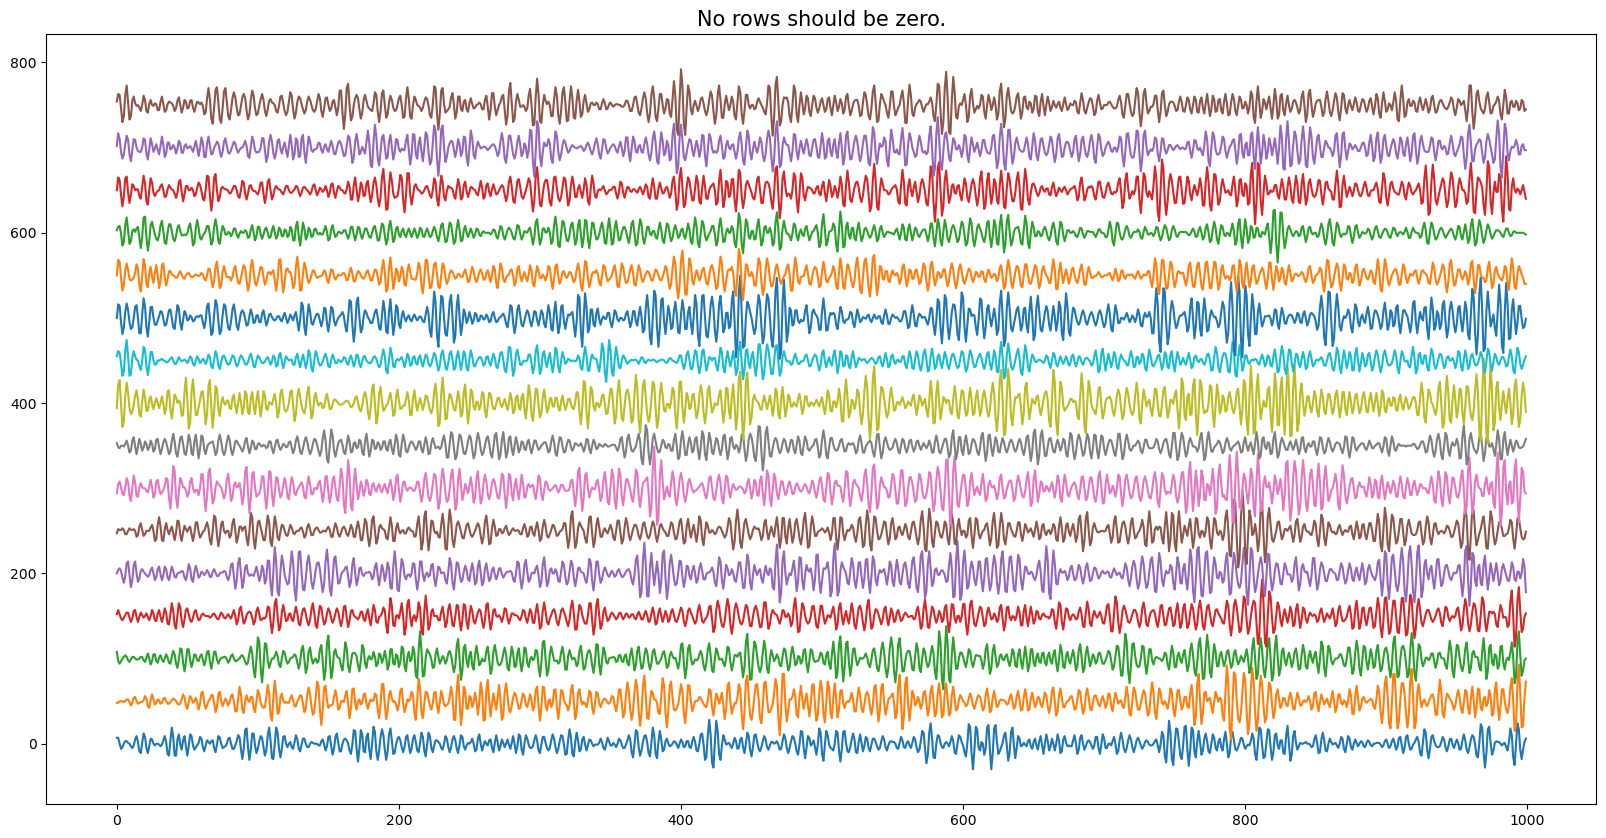

In [69]:
plt.subplots(ncols=1,nrows=1,figsize=(20,10))
r_ind = 0
for i in CA1TetrodeInd:
    plt.plot(filtered_lfps[50000:51000,i]+r_ind*50);
    r_ind += 1;
plt.title('No rows should be zero.',size = 15);

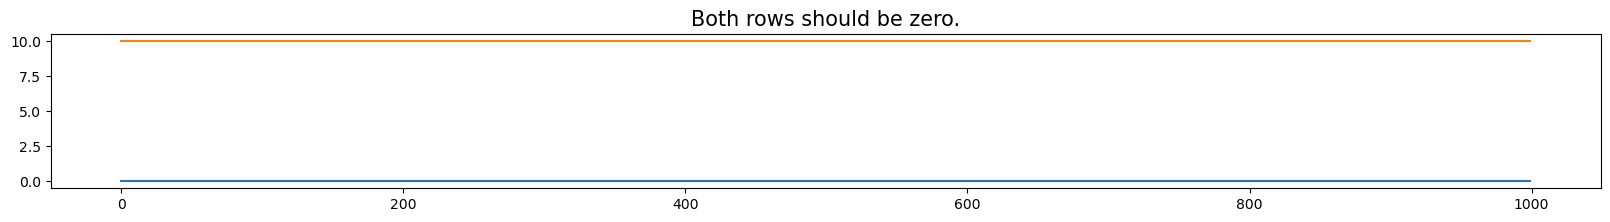

In [70]:
plt.subplots(ncols=1,nrows=1,figsize=(20,2))
r_ind = 0
for i in CCTetrodeInd:
    plt.plot(filtered_lfps[50000:51000,i]+r_ind*10);
    r_ind += 1;
plt.title('Both rows should be zero.',size = 15);

#### 5. To delete an entry

In [49]:
'''Delete an entry'''
#(LFPBand() & {'nwb_file_name' :nwb_copy_file_name,'target_interval_list_name':'04_Seq2Session2'}).delete()

Deleting 1 rows from `common_ephys`.`__l_f_p_band`


Commit deletes? [yes, No]:  yes


Deletes committed.


1

## END HERE

#### filter only "run sessions" for now

In [13]:
epoch_name = '02_Seq2Session1'
lfp_nwb=(LFP & {'nwb_file_name': nwb_copy_file_name,
            'target_interval_list_name':epoch_name}).fetch_nwb()

[2023-08-02 13:32:22,085][WARNING]: Skipped checksum for file with hash: 0751bb0b-0fa3-9f91-c5df-e1b951683a74, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_NXLEK9M4VM.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

In [72]:
# find tetrodes and the corresponding reference_electrode
groups_with_cell=(SpikeSortingRecordingSelection & {'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])

electrodes_ref=[]
for e in groups_with_cell:
    key=(Electrode() & {'nwb_file_name' : nwb_copy_file_name} &{'electrode_group_name' : e})
    electrodes_=key.fetch('electrode_id')
    
    electrodes_ref_=(SortGroup & {'nwb_file_name' : nwb_copy_file_name,
                                  'sort_group_id':e}).fetch('sort_reference_electrode_id')
    if len(electrodes_)>0:
        electrodes_ref.append(electrodes_ref_*np.ones((len(electrodes_))).astype('int'))
        
electrodes_ref=np.unique(electrodes_ref)

In [73]:
electrodes_ref

array([ 4, 72])

In [17]:
lfp_data=lfp_nwb[0]['lfp'].data
lfp_timestamps=np.array(lfp_nwb[0]['lfp'].timestamps)

In [77]:
LFP_electrodes=np.array(list(lfp_nwb[0]['lfp'].electrodes.data))

In [79]:
np.isin(LFP_electrodes,electrodes_ref)

array([ True,  True])

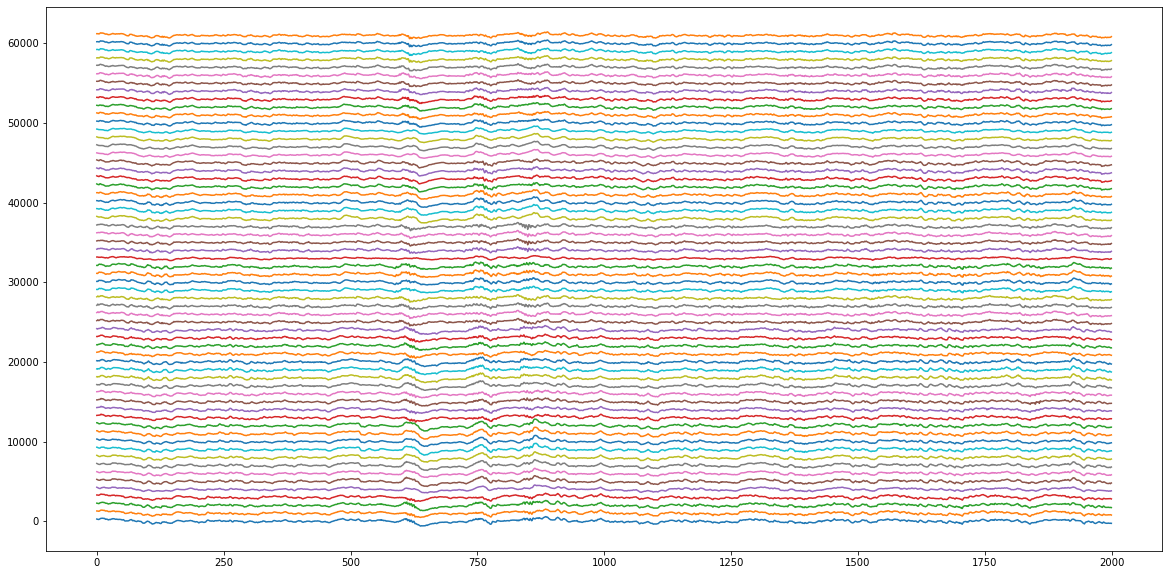

In [58]:
plt.figure(figsize=(20,10))
t1=88000 #75000
t2=t1+2000
for i in range(lfp_data.shape[1]):
    plt.plot(lfp_data[t1:t2,i]+1000*i)
    #plt.plot(lfp_data[t1:t2,0])
    #plt.plot(lfp_data[t1:t2,-1])

In [18]:
electrode_keys = (LFPSelection.LFPElectrode & key).fetch('KEY')

In [40]:
LFP()&{'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
molly20220415_.nwb,lfp valid times,LFP 0-400 Hz,30000,molly20220415_YQD3FYMEG9.nwb,2258037c-7d1d-4ec8-a6ae-1067b1fc4ffb,1000.0


In [ ]:
lowpass(selections[0])

working on tetrode  3
interval_list_name  02_Seq2Session1


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not match length of timestamps. Your data may be transposed. Time should be on "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


LFP: found 1 of 1 intervals > 1.0 sec long.


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not match length of timestamps. Your data may be transposed. Time should be on "


Writing new NWB file molly20220416_WDAD096FWC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


In [13]:
tetrode_interval_list_name=selections[0]
tetrode=tetrode_interval_list_name[0]
interval_list_name=tetrode_interval_list_name[1]
key={'nwb_file_name':nwb_copy_file_name,'interval_list_name': interval_list_name}

In [ ]:
LFP() & {'nwb_file_name':nwb_copy_file_name}

In [ ]:
sampling_rate, interval_list_name = (Raw() & key).fetch1('sampling_rate', 'interval_list_name')

In [ ]:
#LFP().populate([LFPSelection & {'nwb_file_name':nwb_copy_file_name}])

In [24]:
LFP & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
molly20220420_.nwb,lfp valid times,LFP 0-400 Hz,30000,molly20220420_58C6M3SGI8.nwb,6f54fce9-5ba8-457c-b600-b6a91046527b,1000.0


#### 3. do theta/ripple band filter

In [54]:
#(IntervalList() & {'nwb_file_name':nwb_copy_file_name}).fetch('interval_list_name')

In [23]:
(LFPBandSelection() & {'nwb_file_name' :nwb_copy_file_name})

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,min_interval_len the minimum length of a valid interval to filter
molly20220416_.nwb,Ripple 150-250 Hz,1000,02_Seq2Session1,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,04_Seq2Session2,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,06_Seq2Session3,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,08_Seq2Session4,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,10_Seq2Session5,1000,1.0


In [24]:
LFPBand().populate(LFPBandSelection() & {'nwb_file_name' : nwb_copy_file_name})

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1K4.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not ma

Writing new NWB file molly20220416_3VNDUKRCP7.nwb
Interval stop time 1650138099.6804779 is larger than last timestamp 1650138099.6803775, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_3VNDUKRCP7.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_E25011CFZC.nwb
Interval stop time 1650142890.4811482 is larger than last timestamp 1650142890.4810774, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_E25011CFZC.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_S11FBDR1Q2.nwb
Interval stop time 1650146871.9814355 is larger than last timestamp 1650146871.9813447, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_S11FBDR1Q2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_OQ5SXSRYAP.nwb
Interval stop time 1650151262.0815215 is larger than last timestamp 1650151262.0810175, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_OQ5SXSRYAP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_AAIRJ4C4OY.nwb
Interval stop time 1650154867.2815697 is larger than last timestamp 1650154867.2809181, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_AAIRJ4C4OY.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


In [23]:
LFPBand() & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file


In [7]:
raw_eseries = (Raw() & {'nwb_file_name' : nwb_copy_file_name,
                       'electrode_group_name' : 7}).fetch_nwb()[0]['raw']

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/raw/molly20220416_.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not match length of timestamps. Your data may be transposed. Time should be on "


KeyError: '07774c35-a02f-46d8-9cb4-2d90749e073e'

In [8]:
ripple_eseries_all=(LFPBand() & {'nwb_file_name' : nwb_copy_file_name}).fetch_nwb()

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_3OMWOSRN8F.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_BBGZPELQXU.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_SX6OBZOOLP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly

In [9]:
run1times = (IntervalList & {'nwb_file_name': nwb_copy_file_name, 'interval_list_name' : '02_Seq2Session1'}).fetch1('valid_times')
plottimes = [run1times[0][0] + 101, run1times[0][0] + 102]


In [14]:
ripple_eseries=ripple_eseries_all[0]

In [19]:
ripple_eseries

{'nwb_file_name': 'molly20220416_.nwb',
 'filter_name': 'Ripple 150-250 Hz',
 'filter_sampling_rate': 1000,
 'target_interval_list_name': '02_Seq2Session1',
 'lfp_band_sampling_rate': 1000,
 'analysis_file_name': 'molly20220416_3OMWOSRN8F.nwb',
 'interval_list_name': '02_Seq2Session1 lfp band 1000Hz',
 'filtered_data_object_id': '237aa057-9db5-41d0-8225-062310a9a962',
 'filtered_data': filtered data pynwb.ecephys.ElectricalSeries at 0x139743322074608
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (2221581, 1), type "<i2">
   description: no description
   electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
   interval: 1
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (2221581,), type "<f8">
   timestamps_unit: seconds
   unit: volts}

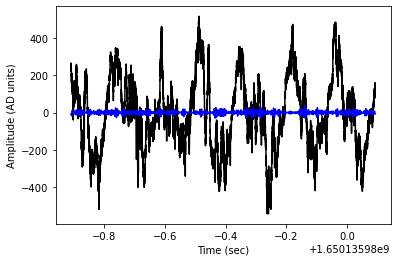

In [46]:
orig_elect_indeces=13
orig_time_ind = np.argwhere(np.logical_and(raw_eseries.timestamps > plottimes[0], raw_eseries.timestamps < plottimes[1]))
lfp_time_ind = np.argwhere(np.logical_and(ripple_eseries.timestamps > plottimes[0], ripple_eseries.timestamps < plottimes[1]))

plt.plot(raw_eseries.timestamps[orig_time_ind], raw_eseries.data[orig_time_ind,orig_elect_indeces], 'k-')
plt.plot(ripple_eseries.timestamps[lfp_time_ind], ripple_eseries.data[lfp_time_ind,0], 'b-')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (AD units)')

plt.show()